In [1]:
import sys

sys.path.append("..")

In [2]:
from tensorflow import keras

In [3]:
from utils.preprocessing_utils import PreprocessingUtils

In [4]:
from utils.model_wrapper import ModelWrapper

In [5]:
preprocessing_utils = PreprocessingUtils()

Files already exist, skipping...
Loading images and labels...
Images and labels loaded successfully!
Preprocessing labels...
Labels preprocessed successfully!
Splitting data into train, test and validation sets...
Data split successfully!


In [6]:
def build_caffe_net(model_name: str):
    model = keras.models.Sequential(
        name=model_name,
        layers=[
            keras.layers.Conv2D(
                filters=3, kernel_size=(11, 11), activation="relu", input_shape=preprocessing_utils.images.shape[1:]
            ),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(
                filters=16, kernel_size=(5, 5), activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)
            ),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(
                filters=96, kernel_size=(3, 3), activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)
            ),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.Flatten(),
            keras.layers.Dense(units=2048, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
            keras.layers.Dense(units=2048, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
            keras.layers.Dense(units=preprocessing_utils.num_classes, activation="softmax"),
        ],
    )

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    model.summary()

    return model

In [7]:
caffe_net_wrapper = ModelWrapper("CaffeNet", preprocessing_utils=preprocessing_utils)

In [8]:
caffe_net_wrapper.build_model(build_fn=build_caffe_net, model_name=caffe_net_wrapper.model_name)

Building model...
Model: "CaffeNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 246, 246, 3)       1092      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 123, 123, 3)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 123, 123, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 119, 119, 16)      1216      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 59, 59, 16)       0         
 2D)                                                             
                                        

In [9]:
caffe_net_wrapper.train_and_save_model()

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 121.9903 - accuracy: 0.0562
Epoch 1: val_loss improved from inf to 51.94664, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 12s 661ms/step - loss: 121.9903 - accuracy: 0.0562 - val_loss: 51.9466 - val_accuracy: 0.0046 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 48.4563 - accuracy: 0.0406
Epoch 2: val_loss improved from 51.94664 to 39.71296, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 5s 587ms/step - loss: 48.4563 - accuracy: 0.0406 - val_loss: 39.7130 - val_accuracy: 0.0415 - lr: 0.0010
Epoch 3/100
8/9 [=========================>....] - ETA: 0s - loss: 35.2603 - accuracy: 0.0775
Epoch 3: val_loss improved from 39.71296 to 32.81050, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 5s 557ms/step - loss: 35.1637 - accuracy: 0.0805 - val_loss: 32.8105 - val_accuracy: 0.0691 - lr: 0.0010
Epoch 4/100
8/9 [=========================>....] - ETA: 0s - loss: 28.8449 - accuracy: 0.1367
Epoch 4: val_loss improved from 32.81050 to 27.41817, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 5s 547ms/step - loss: 28.7739 - accuracy: 0.1377 - val_loss: 27.4182 - val_accuracy: 0.0553 - lr: 0.0010
Epoch 5/100
8/9 [=========================>....] - ETA: 0s - loss: 23.6792 - accuracy: 0.1782
Epoch 5: val_loss improved from 27.41817 to 24.15155, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 5s 526ms/step - loss: 23.6202 - accuracy: 0.1785 - val_loss: 24.1516 - val_accuracy: 0.0369 - lr: 0.0010
Epoch 6/100
8/9 [=========================>....] - ETA: 0s - loss: 19.5345 - accuracy: 0.2210
Epoch 6: val_loss improved from 24.15155 to 19.94583, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 5s 549ms/step - loss: 19.4887 - accuracy: 0.2209 - val_loss: 19.9458 - val_accuracy: 0.0323 - lr: 0.0010
Epoch 7/100
8/9 [=========================>....] - ETA: 0s - loss: 16.4110 - accuracy: 0.2307
Epoch 7: val_loss improved from 19.94583 to 18.19792, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 5s 538ms/step - loss: 16.3755 - accuracy: 0.2316 - val_loss: 18.1979 - val_accuracy: 0.0553 - lr: 0.0010
Epoch 8/100
8/9 [=========================>....] - ETA: 0s - loss: 14.0421 - accuracy: 0.2407
Epoch 8: val_loss improved from 18.19792 to 16.56127, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 5s 535ms/step - loss: 14.0192 - accuracy: 0.2398 - val_loss: 16.5613 - val_accuracy: 0.0415 - lr: 0.0010
Epoch 9/100
8/9 [=========================>....] - ETA: 0s - loss: 12.3104 - accuracy: 0.2598
Epoch 9: val_loss improved from 16.56127 to 12.98129, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 5s 544ms/step - loss: 12.2951 - accuracy: 0.2581 - val_loss: 12.9813 - val_accuracy: 0.0737 - lr: 0.0010
Epoch 10/100
8/9 [=========================>....] - ETA: 0s - loss: 11.0874 - accuracy: 0.2603
Epoch 10: val_loss improved from 12.98129 to 12.49357, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 5s 537ms/step - loss: 11.0775 - accuracy: 0.2608 - val_loss: 12.4936 - val_accuracy: 0.0783 - lr: 0.0010
Epoch 11/100
8/9 [=========================>....] - ETA: 0s - loss: 10.1662 - accuracy: 0.2837
Epoch 11: val_loss improved from 12.49357 to 11.58218, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 5s 527ms/step - loss: 10.1617 - accuracy: 0.2824 - val_loss: 11.5822 - val_accuracy: 0.0599 - lr: 0.0010
Epoch 12/100
8/9 [=========================>....] - ETA: 0s - loss: 9.4533 - accuracy: 0.3072
Epoch 12: val_loss improved from 11.58218 to 10.85464, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 5s 545ms/step - loss: 9.4443 - accuracy: 0.3087 - val_loss: 10.8546 - val_accuracy: 0.0507 - lr: 0.0010
Epoch 13/100
8/9 [=========================>....] - ETA: 0s - loss: 8.9141 - accuracy: 0.3228
Epoch 13: val_loss improved from 10.85464 to 10.27830, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 5s 530ms/step - loss: 8.9176 - accuracy: 0.3216 - val_loss: 10.2783 - val_accuracy: 0.0691 - lr: 0.0010
Epoch 14/100
8/9 [=========================>....] - ETA: 0s - loss: 8.5088 - accuracy: 0.3478
Epoch 14: val_loss did not improve from 10.27830
9/9 [==============================] - 2s 163ms/step - loss: 8.5060 - accuracy: 0.3469 - val_loss: 10.6777 - val_accuracy: 0.0876 - lr: 0.0010
Epoch 15/100
8/9 [=========================>....] - ETA: 0s - loss: 8.2419 - accuracy: 0.3450
Epoch 15: val_loss improved from 10.27830 to 9.72579, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 527ms/step - loss: 8.2315 - accuracy: 0.3471 - val_loss: 9.7258 - val_accuracy: 0.0968 - lr: 0.0010
Epoch 16/100
8/9 [=========================>....] - ETA: 0s - loss: 7.9022 - accuracy: 0.3873
Epoch 16: val_loss improved from 9.72579 to 9.65361, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 525ms/step - loss: 7.9041 - accuracy: 0.3846 - val_loss: 9.6536 - val_accuracy: 0.0645 - lr: 0.0010
Epoch 17/100
8/9 [=========================>....] - ETA: 0s - loss: 7.7943 - accuracy: 0.3785
Epoch 17: val_loss improved from 9.65361 to 9.10854, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 517ms/step - loss: 7.7930 - accuracy: 0.3785 - val_loss: 9.1085 - val_accuracy: 0.1567 - lr: 0.0010
Epoch 18/100
8/9 [=========================>....] - ETA: 0s - loss: 7.5950 - accuracy: 0.4225
Epoch 18: val_loss improved from 9.10854 to 8.85613, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 5s 528ms/step - loss: 7.5967 - accuracy: 0.4211 - val_loss: 8.8561 - val_accuracy: 0.1336 - lr: 0.0010
Epoch 19/100
8/9 [=========================>....] - ETA: 0s - loss: 7.3784 - accuracy: 0.4355
Epoch 19: val_loss did not improve from 8.85613
9/9 [==============================] - 2s 163ms/step - loss: 7.3791 - accuracy: 0.4340 - val_loss: 8.9409 - val_accuracy: 0.1152 - lr: 0.0010
Epoch 20/100
8/9 [=========================>....] - ETA: 0s - loss: 7.2229 - accuracy: 0.4518
Epoch 20: val_loss improved from 8.85613 to 8.69002, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 525ms/step - loss: 7.2233 - accuracy: 0.4507 - val_loss: 8.6900 - val_accuracy: 0.1336 - lr: 0.0010
Epoch 21/100
8/9 [=========================>....] - ETA: 0s - loss: 7.0278 - accuracy: 0.4888
Epoch 21: val_loss did not improve from 8.69002
9/9 [==============================] - 2s 158ms/step - loss: 7.0320 - accuracy: 0.4867 - val_loss: 8.7361 - val_accuracy: 0.1567 - lr: 0.0010
Epoch 22/100
8/9 [=========================>....] - ETA: 0s - loss: 7.0308 - accuracy: 0.4715
Epoch 22: val_loss improved from 8.69002 to 8.44067, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 521ms/step - loss: 7.0285 - accuracy: 0.4724 - val_loss: 8.4407 - val_accuracy: 0.1659 - lr: 0.0010
Epoch 23/100
8/9 [=========================>....] - ETA: 0s - loss: 6.8838 - accuracy: 0.5075
Epoch 23: val_loss did not improve from 8.44067
9/9 [==============================] - 2s 161ms/step - loss: 6.8851 - accuracy: 0.5069 - val_loss: 8.4886 - val_accuracy: 0.1935 - lr: 0.0010
Epoch 24/100
8/9 [=========================>....] - ETA: 0s - loss: 6.7913 - accuracy: 0.5315
Epoch 24: val_loss did not improve from 8.44067
9/9 [==============================] - 1s 164ms/step - loss: 6.7921 - accuracy: 0.5310 - val_loss: 8.7119 - val_accuracy: 0.1567 - lr: 0.0010
Epoch 25/100
8/9 [=========================>....] - ETA: 0s - loss: 6.6250 - accuracy: 0.5585
Epoch 25: val_loss improved from 8.44067 to 8.36867, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 540ms/step - loss: 6.6287 - accuracy: 0.5561 - val_loss: 8.3687 - val_accuracy: 0.1705 - lr: 0.0010
Epoch 26/100
8/9 [=========================>....] - ETA: 0s - loss: 6.4891 - accuracy: 0.5677
Epoch 26: val_loss improved from 8.36867 to 8.22291, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 5s 541ms/step - loss: 6.4873 - accuracy: 0.5682 - val_loss: 8.2229 - val_accuracy: 0.1889 - lr: 0.0010
Epoch 27/100
8/9 [=========================>....] - ETA: 0s - loss: 6.3855 - accuracy: 0.5738
Epoch 27: val_loss did not improve from 8.22291
9/9 [==============================] - 2s 161ms/step - loss: 6.3871 - accuracy: 0.5729 - val_loss: 8.2509 - val_accuracy: 0.2166 - lr: 0.0010
Epoch 28/100
8/9 [=========================>....] - ETA: 0s - loss: 6.2603 - accuracy: 0.6050
Epoch 28: val_loss improved from 8.22291 to 8.21168, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 525ms/step - loss: 6.2595 - accuracy: 0.6062 - val_loss: 8.2117 - val_accuracy: 0.2212 - lr: 0.0010
Epoch 29/100
8/9 [=========================>....] - ETA: 0s - loss: 6.1000 - accuracy: 0.6453
Epoch 29: val_loss did not improve from 8.21168
9/9 [==============================] - 2s 158ms/step - loss: 6.0993 - accuracy: 0.6453 - val_loss: 8.2513 - val_accuracy: 0.1935 - lr: 0.0010
Epoch 30/100
8/9 [=========================>....] - ETA: 0s - loss: 6.0500 - accuracy: 0.6363
Epoch 30: val_loss improved from 8.21168 to 8.09117, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 534ms/step - loss: 6.0443 - accuracy: 0.6380 - val_loss: 8.0912 - val_accuracy: 0.1935 - lr: 0.0010
Epoch 31/100
8/9 [=========================>....] - ETA: 0s - loss: 5.8951 - accuracy: 0.6678
Epoch 31: val_loss did not improve from 8.09117
9/9 [==============================] - 2s 160ms/step - loss: 5.8917 - accuracy: 0.6687 - val_loss: 8.0923 - val_accuracy: 0.1889 - lr: 0.0010
Epoch 32/100
8/9 [=========================>....] - ETA: 0s - loss: 5.8563 - accuracy: 0.6575
Epoch 32: val_loss did not improve from 8.09117
9/9 [==============================] - 1s 161ms/step - loss: 5.8518 - accuracy: 0.6592 - val_loss: 8.1696 - val_accuracy: 0.2120 - lr: 0.0010
Epoch 33/100
8/9 [=========================>....] - ETA: 0s - loss: 5.7131 - accuracy: 0.6955
Epoch 33: val_loss improved from 8.09117 to 8.07508, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 522ms/step - loss: 5.7134 - accuracy: 0.6942 - val_loss: 8.0751 - val_accuracy: 0.1843 - lr: 0.0010
Epoch 34/100
8/9 [=========================>....] - ETA: 0s - loss: 5.5834 - accuracy: 0.7393
Epoch 34: val_loss did not improve from 8.07508
9/9 [==============================] - 2s 161ms/step - loss: 5.5864 - accuracy: 0.7366 - val_loss: 8.4665 - val_accuracy: 0.1613 - lr: 0.0010
Epoch 35/100
8/9 [=========================>....] - ETA: 0s - loss: 5.5995 - accuracy: 0.7013
Epoch 35: val_loss improved from 8.07508 to 7.83123, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 537ms/step - loss: 5.5994 - accuracy: 0.7025 - val_loss: 7.8312 - val_accuracy: 0.2581 - lr: 0.0010
Epoch 36/100
8/9 [=========================>....] - ETA: 0s - loss: 5.3852 - accuracy: 0.7753
Epoch 36: val_loss did not improve from 7.83123
9/9 [==============================] - 2s 159ms/step - loss: 5.3889 - accuracy: 0.7726 - val_loss: 8.1215 - val_accuracy: 0.2212 - lr: 0.0010
Epoch 37/100
8/9 [=========================>....] - ETA: 0s - loss: 5.3269 - accuracy: 0.7640
Epoch 37: val_loss did not improve from 7.83123
9/9 [==============================] - 1s 162ms/step - loss: 5.3376 - accuracy: 0.7599 - val_loss: 8.1355 - val_accuracy: 0.2304 - lr: 0.0010
Epoch 38/100
8/9 [=========================>....] - ETA: 0s - loss: 5.3336 - accuracy: 0.7495
Epoch 38: val_loss did not improve from 7.83123
9/9 [==============================] - 1s 163ms/step - loss: 5.3317 - accuracy: 0.7504 - val_loss: 7.9906 - val_accuracy: 0.2120 - lr: 0.0010
Epoch 

INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 521ms/step - loss: 5.0154 - accuracy: 0.8416 - val_loss: 7.7212 - val_accuracy: 0.2488 - lr: 5.0000e-04
Epoch 40/100
8/9 [=========================>....] - ETA: 0s - loss: 4.7101 - accuracy: 0.9137
Epoch 40: val_loss improved from 7.72116 to 7.41216, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 521ms/step - loss: 4.7089 - accuracy: 0.9136 - val_loss: 7.4122 - val_accuracy: 0.2258 - lr: 5.0000e-04
Epoch 41/100
8/9 [=========================>....] - ETA: 0s - loss: 4.4697 - accuracy: 0.9555
Epoch 41: val_loss did not improve from 7.41216
9/9 [==============================] - 2s 157ms/step - loss: 4.4685 - accuracy: 0.9555 - val_loss: 7.4791 - val_accuracy: 0.2442 - lr: 5.0000e-04
Epoch 42/100
8/9 [=========================>....] - ETA: 0s - loss: 4.3118 - accuracy: 0.9643
Epoch 42: val_loss improved from 7.41216 to 7.25702, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 535ms/step - loss: 4.3123 - accuracy: 0.9635 - val_loss: 7.2570 - val_accuracy: 0.2488 - lr: 5.0000e-04
Epoch 43/100
8/9 [=========================>....] - ETA: 0s - loss: 4.1991 - accuracy: 0.9732
Epoch 43: val_loss did not improve from 7.25702
9/9 [==============================] - 2s 157ms/step - loss: 4.1989 - accuracy: 0.9732 - val_loss: 7.3629 - val_accuracy: 0.2396 - lr: 5.0000e-04
Epoch 44/100
8/9 [=========================>....] - ETA: 0s - loss: 4.1099 - accuracy: 0.9768
Epoch 44: val_loss did not improve from 7.25702
9/9 [==============================] - 1s 156ms/step - loss: 4.1094 - accuracy: 0.9769 - val_loss: 7.2702 - val_accuracy: 0.2304 - lr: 5.0000e-04
Epoch 45/100
8/9 [=========================>....] - ETA: 0s - loss: 4.0368 - accuracy: 0.9780
Epoch 45: val_loss did not improve from 7.25702
9/9 [==============================] - 1s 158ms/step - loss: 4.0384 - accuracy: 0.9769 - val_loss: 7.2571 - val_accuracy: 0.2350 - lr: 5

INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 521ms/step - loss: 3.9031 - accuracy: 0.9939 - val_loss: 7.1490 - val_accuracy: 0.2258 - lr: 2.5000e-04
Epoch 48/100
8/9 [=========================>....] - ETA: 0s - loss: 3.8530 - accuracy: 0.9965
Epoch 48: val_loss did not improve from 7.14896
9/9 [==============================] - 2s 165ms/step - loss: 3.8525 - accuracy: 0.9966 - val_loss: 7.2165 - val_accuracy: 0.2212 - lr: 2.5000e-04
Epoch 49/100
8/9 [=========================>....] - ETA: 0s - loss: 3.8113 - accuracy: 0.9975
Epoch 49: val_loss improved from 7.14896 to 7.12684, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 518ms/step - loss: 3.8118 - accuracy: 0.9976 - val_loss: 7.1268 - val_accuracy: 0.2212 - lr: 2.5000e-04
Epoch 50/100
8/9 [=========================>....] - ETA: 0s - loss: 3.7749 - accuracy: 0.9995
Epoch 50: val_loss improved from 7.12684 to 7.08322, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 5s 531ms/step - loss: 3.7754 - accuracy: 0.9995 - val_loss: 7.0832 - val_accuracy: 0.2258 - lr: 2.5000e-04
Epoch 51/100
8/9 [=========================>....] - ETA: 0s - loss: 3.7520 - accuracy: 0.9987
Epoch 51: val_loss did not improve from 7.08322
9/9 [==============================] - 2s 159ms/step - loss: 3.7519 - accuracy: 0.9988 - val_loss: 7.0957 - val_accuracy: 0.2304 - lr: 2.5000e-04
Epoch 52/100
8/9 [=========================>....] - ETA: 0s - loss: 3.7235 - accuracy: 0.9967
Epoch 52: val_loss did not improve from 7.08322
9/9 [==============================] - 1s 158ms/step - loss: 3.7231 - accuracy: 0.9968 - val_loss: 7.1034 - val_accuracy: 0.2304 - lr: 2.5000e-04
Epoch 53/100
8/9 [=========================>....] - ETA: 0s - loss: 3.6947 - accuracy: 0.9992
Epoch 53: val_loss improved from 7.08322 to 7.07414, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 518ms/step - loss: 3.6942 - accuracy: 0.9993 - val_loss: 7.0741 - val_accuracy: 0.2212 - lr: 2.5000e-04
Epoch 54/100
8/9 [=========================>....] - ETA: 0s - loss: 3.6681 - accuracy: 0.9990
Epoch 54: val_loss did not improve from 7.07414
9/9 [==============================] - 2s 160ms/step - loss: 3.6674 - accuracy: 0.9988 - val_loss: 7.1149 - val_accuracy: 0.2304 - lr: 2.5000e-04
Epoch 55/100
8/9 [=========================>....] - ETA: 0s - loss: 3.6443 - accuracy: 0.9992
Epoch 55: val_loss did not improve from 7.07414
9/9 [==============================] - 1s 162ms/step - loss: 3.6442 - accuracy: 0.9993 - val_loss: 7.1132 - val_accuracy: 0.2396 - lr: 2.5000e-04
Epoch 56/100
8/9 [=========================>....] - ETA: 0s - loss: 3.6186 - accuracy: 0.9987
Epoch 56: val_loss improved from 7.07414 to 7.05098, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 520ms/step - loss: 3.6188 - accuracy: 0.9988 - val_loss: 7.0510 - val_accuracy: 0.2212 - lr: 2.5000e-04
Epoch 57/100
8/9 [=========================>....] - ETA: 0s - loss: 3.5972 - accuracy: 0.9985
Epoch 57: val_loss did not improve from 7.05098
9/9 [==============================] - 2s 163ms/step - loss: 3.5969 - accuracy: 0.9985 - val_loss: 7.0695 - val_accuracy: 0.2166 - lr: 2.5000e-04
Epoch 58/100
8/9 [=========================>....] - ETA: 0s - loss: 3.5694 - accuracy: 1.0000
Epoch 58: val_loss improved from 7.05098 to 6.97868, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 538ms/step - loss: 3.5690 - accuracy: 1.0000 - val_loss: 6.9787 - val_accuracy: 0.2304 - lr: 2.5000e-04
Epoch 59/100
8/9 [=========================>....] - ETA: 0s - loss: 3.5463 - accuracy: 0.9998
Epoch 59: val_loss improved from 6.97868 to 6.97732, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 526ms/step - loss: 3.5471 - accuracy: 0.9998 - val_loss: 6.9773 - val_accuracy: 0.2488 - lr: 2.5000e-04
Epoch 60/100
8/9 [=========================>....] - ETA: 0s - loss: 3.5288 - accuracy: 0.9990
Epoch 60: val_loss improved from 6.97732 to 6.96946, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 5s 533ms/step - loss: 3.5289 - accuracy: 0.9988 - val_loss: 6.9695 - val_accuracy: 0.2442 - lr: 2.5000e-04
Epoch 61/100
8/9 [=========================>....] - ETA: 0s - loss: 3.5086 - accuracy: 0.9995
Epoch 61: val_loss did not improve from 6.96946
9/9 [==============================] - 2s 163ms/step - loss: 3.5087 - accuracy: 0.9995 - val_loss: 6.9847 - val_accuracy: 0.2350 - lr: 2.5000e-04
Epoch 62/100
8/9 [=========================>....] - ETA: 0s - loss: 3.4903 - accuracy: 0.9992
Epoch 62: val_loss improved from 6.96946 to 6.95219, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 530ms/step - loss: 3.4896 - accuracy: 0.9993 - val_loss: 6.9522 - val_accuracy: 0.2304 - lr: 2.5000e-04
Epoch 63/100
8/9 [=========================>....] - ETA: 0s - loss: 3.4652 - accuracy: 0.9995
Epoch 63: val_loss improved from 6.95219 to 6.94869, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 5s 534ms/step - loss: 3.4651 - accuracy: 0.9995 - val_loss: 6.9487 - val_accuracy: 0.2535 - lr: 2.5000e-04
Epoch 64/100
8/9 [=========================>....] - ETA: 0s - loss: 3.4451 - accuracy: 0.9995
Epoch 64: val_loss improved from 6.94869 to 6.94469, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 5s 544ms/step - loss: 3.4454 - accuracy: 0.9995 - val_loss: 6.9447 - val_accuracy: 0.2166 - lr: 2.5000e-04
Epoch 65/100
8/9 [=========================>....] - ETA: 0s - loss: 3.4234 - accuracy: 1.0000
Epoch 65: val_loss improved from 6.94469 to 6.89850, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 5s 552ms/step - loss: 3.4234 - accuracy: 1.0000 - val_loss: 6.8985 - val_accuracy: 0.2258 - lr: 2.5000e-04
Epoch 66/100
8/9 [=========================>....] - ETA: 0s - loss: 3.4004 - accuracy: 1.0000
Epoch 66: val_loss did not improve from 6.89850
9/9 [==============================] - 2s 162ms/step - loss: 3.4011 - accuracy: 1.0000 - val_loss: 6.9748 - val_accuracy: 0.2212 - lr: 2.5000e-04
Epoch 67/100
8/9 [=========================>....] - ETA: 0s - loss: 3.3897 - accuracy: 0.9995
Epoch 67: val_loss did not improve from 6.89850
9/9 [==============================] - 2s 176ms/step - loss: 3.3894 - accuracy: 0.9995 - val_loss: 6.9564 - val_accuracy: 0.2166 - lr: 2.5000e-04
Epoch 68/100
8/9 [=========================>....] - ETA: 0s - loss: 3.3589 - accuracy: 1.0000
Epoch 68: val_loss did not improve from 6.89850
9/9 [==============================] - 2s 168ms/step - loss: 3.3591 - accuracy: 1.0000 - val_loss: 6.9295 - val_accuracy: 0.2212 - lr: 2

INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 529ms/step - loss: 3.3419 - accuracy: 0.9998 - val_loss: 6.8554 - val_accuracy: 0.2212 - lr: 1.2500e-04
Epoch 70/100
8/9 [=========================>....] - ETA: 0s - loss: 3.3222 - accuracy: 1.0000
Epoch 70: val_loss improved from 6.85544 to 6.84883, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 5s 540ms/step - loss: 3.3219 - accuracy: 1.0000 - val_loss: 6.8488 - val_accuracy: 0.2258 - lr: 1.2500e-04
Epoch 71/100
8/9 [=========================>....] - ETA: 0s - loss: 3.3113 - accuracy: 1.0000
Epoch 71: val_loss improved from 6.84883 to 6.84367, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 526ms/step - loss: 3.3115 - accuracy: 1.0000 - val_loss: 6.8437 - val_accuracy: 0.2350 - lr: 1.2500e-04
Epoch 72/100
8/9 [=========================>....] - ETA: 0s - loss: 3.2968 - accuracy: 1.0000
Epoch 72: val_loss did not improve from 6.84367
9/9 [==============================] - 2s 162ms/step - loss: 3.2968 - accuracy: 1.0000 - val_loss: 6.8811 - val_accuracy: 0.2258 - lr: 1.2500e-04
Epoch 73/100
8/9 [=========================>....] - ETA: 0s - loss: 3.2853 - accuracy: 1.0000
Epoch 73: val_loss did not improve from 6.84367
9/9 [==============================] - 1s 157ms/step - loss: 3.2852 - accuracy: 1.0000 - val_loss: 6.8584 - val_accuracy: 0.2304 - lr: 1.2500e-04
Epoch 74/100
8/9 [=========================>....] - ETA: 0s - loss: 3.2725 - accuracy: 1.0000
Epoch 74: val_loss did not improve from 6.84367
9/9 [==============================] - 1s 157ms/step - loss: 3.2726 - accuracy: 1.0000 - val_loss: 6.8483 - val_accuracy: 0.2166 - lr: 1

INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 525ms/step - loss: 3.2620 - accuracy: 1.0000 - val_loss: 6.8398 - val_accuracy: 0.2212 - lr: 6.2500e-05
Epoch 76/100
8/9 [=========================>....] - ETA: 0s - loss: 3.2543 - accuracy: 1.0000
Epoch 76: val_loss improved from 6.83979 to 6.82473, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 5s 535ms/step - loss: 3.2549 - accuracy: 1.0000 - val_loss: 6.8247 - val_accuracy: 0.2212 - lr: 6.2500e-05
Epoch 77/100
8/9 [=========================>....] - ETA: 0s - loss: 3.2495 - accuracy: 1.0000
Epoch 77: val_loss improved from 6.82473 to 6.82038, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 519ms/step - loss: 3.2496 - accuracy: 1.0000 - val_loss: 6.8204 - val_accuracy: 0.2212 - lr: 6.2500e-05
Epoch 78/100
8/9 [=========================>....] - ETA: 0s - loss: 3.2442 - accuracy: 1.0000
Epoch 78: val_loss did not improve from 6.82038
9/9 [==============================] - 2s 156ms/step - loss: 3.2446 - accuracy: 1.0000 - val_loss: 6.8293 - val_accuracy: 0.2166 - lr: 6.2500e-05
Epoch 79/100
8/9 [=========================>....] - ETA: 0s - loss: 3.2394 - accuracy: 1.0000
Epoch 79: val_loss improved from 6.82038 to 6.81873, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 535ms/step - loss: 3.2397 - accuracy: 1.0000 - val_loss: 6.8187 - val_accuracy: 0.2304 - lr: 6.2500e-05
Epoch 80/100
8/9 [=========================>....] - ETA: 0s - loss: 3.2326 - accuracy: 1.0000
Epoch 80: val_loss did not improve from 6.81873
9/9 [==============================] - 2s 157ms/step - loss: 3.2327 - accuracy: 1.0000 - val_loss: 6.8216 - val_accuracy: 0.2212 - lr: 6.2500e-05
Epoch 81/100
8/9 [=========================>....] - ETA: 0s - loss: 3.2277 - accuracy: 1.0000
Epoch 81: val_loss improved from 6.81873 to 6.80685, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 4s 524ms/step - loss: 3.2283 - accuracy: 0.9998 - val_loss: 6.8068 - val_accuracy: 0.2212 - lr: 6.2500e-05
Epoch 82/100
8/9 [=========================>....] - ETA: 0s - loss: 3.2253 - accuracy: 1.0000
Epoch 82: val_loss improved from 6.80685 to 6.78530, saving model to ../../artifacts/checkpoints\checkpoint_CaffeNet


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 5s 528ms/step - loss: 3.2252 - accuracy: 1.0000 - val_loss: 6.7853 - val_accuracy: 0.2258 - lr: 6.2500e-05
Epoch 83/100
8/9 [=========================>....] - ETA: 0s - loss: 3.2193 - accuracy: 1.0000
Epoch 83: val_loss did not improve from 6.78530
9/9 [==============================] - 2s 159ms/step - loss: 3.2194 - accuracy: 1.0000 - val_loss: 6.8151 - val_accuracy: 0.2442 - lr: 6.2500e-05
Epoch 84/100
8/9 [=========================>....] - ETA: 0s - loss: 3.2131 - accuracy: 1.0000
Epoch 84: val_loss did not improve from 6.78530
9/9 [==============================] - 1s 160ms/step - loss: 3.2131 - accuracy: 1.0000 - val_loss: 6.8026 - val_accuracy: 0.2258 - lr: 6.2500e-05
Epoch 85/100
8/9 [=========================>....] - ETA: 0s - loss: 3.2087 - accuracy: 1.0000
Epoch 85: val_loss did not improve from 6.78530
9/9 [==============================] - 2s 177ms/step - loss: 3.2089 - accuracy: 1.0000 - val_loss: 6.7973 - val_accuracy: 0.2166 - lr: 6

INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


INFO:tensorflow:Assets written to: ../../artifacts/checkpoints\checkpoint_CaffeNet\assets


9/9 [==============================] - 5s 552ms/step - loss: 3.2013 - accuracy: 1.0000 - val_loss: 6.7828 - val_accuracy: 0.2350 - lr: 3.1250e-05
Epoch 87/100
8/9 [=========================>....] - ETA: 0s - loss: 3.1985 - accuracy: 1.0000
Epoch 87: val_loss did not improve from 6.78275
9/9 [==============================] - 2s 162ms/step - loss: 3.1983 - accuracy: 1.0000 - val_loss: 6.8017 - val_accuracy: 0.2396 - lr: 3.1250e-05
Epoch 88/100
8/9 [=========================>....] - ETA: 0s - loss: 3.1946 - accuracy: 1.0000
Epoch 88: val_loss did not improve from 6.78275
9/9 [==============================] - 1s 157ms/step - loss: 3.1968 - accuracy: 1.0000 - val_loss: 6.7939 - val_accuracy: 0.2258 - lr: 3.1250e-05
Epoch 89/100
8/9 [=========================>....] - ETA: 0s - loss: 3.1938 - accuracy: 1.0000
Epoch 89: val_loss did not improve from 6.78275
9/9 [==============================] - 1s 157ms/step - loss: 3.1939 - accuracy: 1.0000 - val_loss: 6.7891 - val_accuracy: 0.2442 - lr: 3

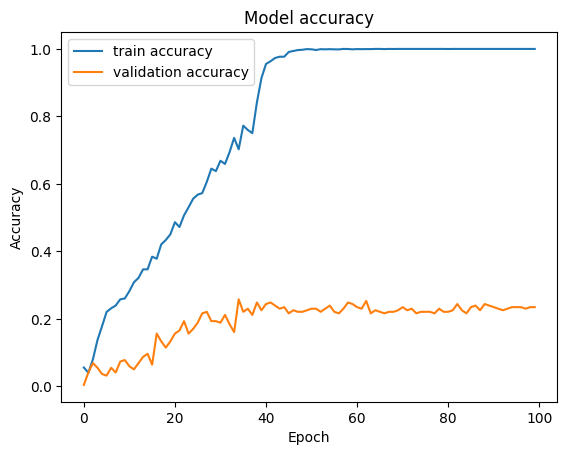

In [10]:
caffe_net_wrapper.plot_accuracy()

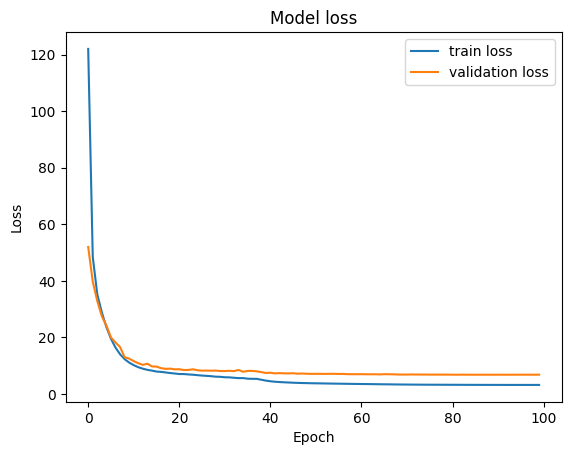

In [11]:
caffe_net_wrapper.plot_loss()

In [12]:
caffe_net_wrapper.load_model()

Loading model from "../../artifacts/models/CaffeNet.h5"...
Model loaded successfully!


20/20 [==============================] - 0s 10ms/step - loss: 6.9337 - accuracy: 0.2375
Loss: 6.9337
Accuracy: 0.2375
20/20 [==============================] - 0s 6ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.09      0.09        23
           1       0.35      0.28      0.31        25
           2       0.43      0.44      0.44        52
           3       0.16      0.18      0.17        38
           4       0.05      0.04      0.04        27
           5       0.20      0.26      0.22        35
           6       0.32      0.22      0.26        45
           7       0.00      0.00      0.00        10
           8       0.29      0.33      0.31        12
           9       0.33      0.27      0.30        11
          10       0.21      0.22      0.21        23
          11       0.30      0.31      0.30        26
          12       0.17      0.22      0.19        32
          13       0.11      0.13      0.12      

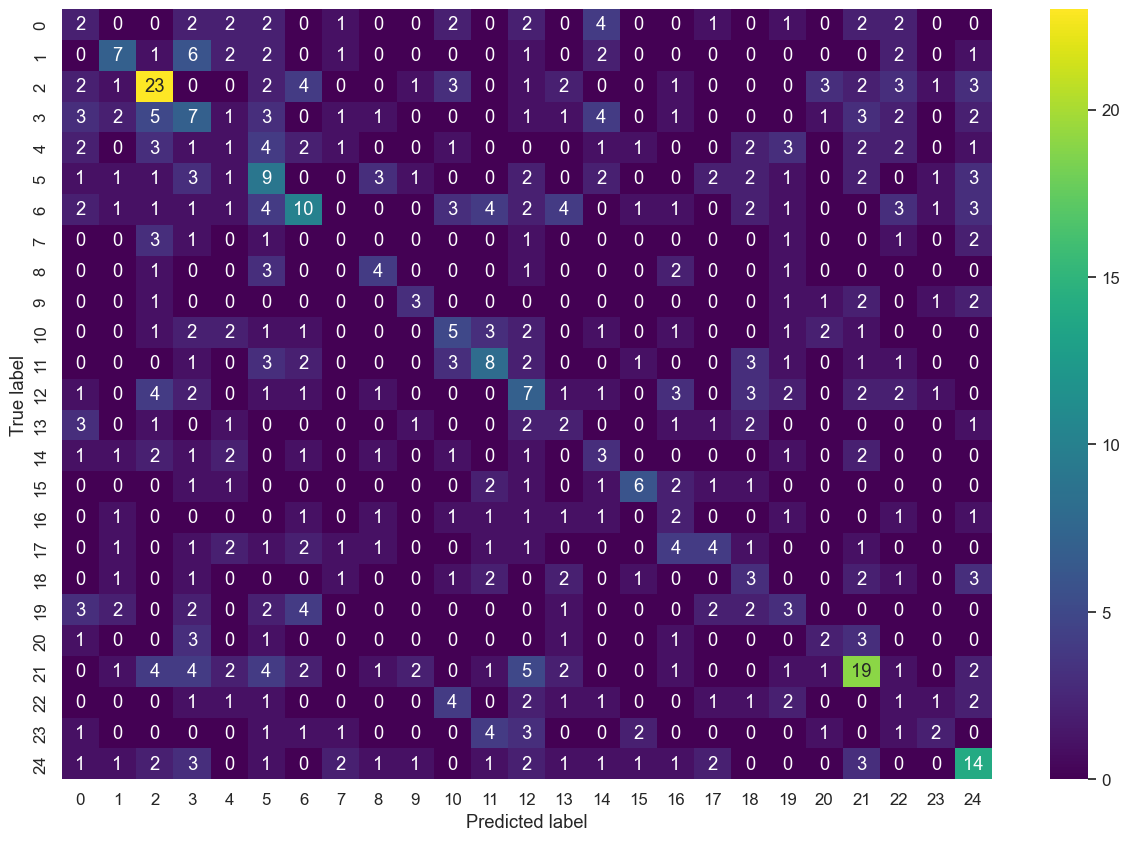

In [13]:
caffe_net_wrapper.display_evaluation_results()